#### <mark>**Problem 1**</mark>

MDP Definition
An MDP is defined by the tuple: (S, A, P, R, γ)

* S is State Space (S)
* A is Action Space (A)
* P is a state transition probability matrix 
$$P_{ss'} = \mathbb{P}[S_{t+1} = s' \mid S_t = s, A_t = a]$$
* R is a reward function 
$$R_s = \mathbb{E}[R_{t+1} \mid S_t = s, A_t = a]$$
* γ is a discount factor
$$\gamma \in [0, 1]$$

___

**The State Space (S)**
The state must provide a complete snapshot of the system's physical configuration so the agent can predict the outcome of its actions.
* Joint Positions: The current position of each linkage (angles or displacements).
* Joint Velocities: Necessary to account for momentum and ensure smoothness (penalizing jerk or acceleration).
* End-Effector Position: The (x, y, z) coordinates of the "hand" relative to the target object (position + orientation). End-effector pose can be derived from joint states, but including it improves learning stability.
* Object Status: Position of the object to be picked.
* Gripper Status: Whether the gripper has successfully secured the object (open/closed or force)

Reasoning: 
* Without velocity data, the agent cannot perceive "smoothness" or deceleration, leading to jerky movements or overshooting.
* Explicit goal information allows generalization across different pick-and-place locations.
* Positions + velocities fully describe the arm’s dynamics.

___

**The Action Space (A)**
Because we want fast and smooth movements, actions should be continuous and low-level. We avoid discrete steps (like Up, Down, Right, Left).
* Torque Control (τ): The agent sends a specific amount of electric current/force to each motor at every time step: $$a_t = \tau_t$$
    - Pros:
        1. Maximum control authority
        2. Learns smooth, dynamic motions

    - Cons: Harder to learn, requires more data

* Alternative (Velocity Control): Specifying desired angular velocities, though torque control is the "gold standard" for truly fluid, human-like motion.

    - Pros: 
        1. More stable learning
        2. Still supports smooth movements

Reasoning: 
Controlling torques allows the agent to utilize gravity and inertia, which is essential for high-speed efficiency.

___

**The Reward Function (R)**
The reward function is the most critical part of the design. It must balance competing goals: accuracy, speed, and mechanical preservation. A composite reward function might look like this:
$$R = W_1(R_{\text{task}}) - W_2(R_{\text{energy}}) - W_3(R_{\text{jerk}})$$

Objectives: 
1. Reach the target accurately (accuracy)
2. Do it quickly (Speed)
3. Move smoothly and avoid excessive forces or unsafe behaviour

| Component | Definition | Reasoning |
| :--- | :--- | :--- |
| **Task Success** | Large positive reward for placing the object; negative penalty based on distance to target. | Drives the agent toward the primary goal. |
| **Energy Penalty** | A penalty proportional to the square of the torques applied. | Encourages efficiency and prevents "over-powering" the motors. |
| **Smoothness (Jerk)** | A penalty on the derivative of acceleration (change in torque). | **Crucial for smoothness.** It penalizes sudden, vibrating movements that cause wear and tear. |
| **Time Penalty** | A small negative reward for every step taken. | Incentivizes the "fast" requirement. |
___

**The Transition Dynamics (P) and Environment**
* Transition Function: $$\mathbb{P}(s_{t+1} \mid s_t, a_t)$$
* Time Step (∆t): Must be very small (e.g., 1ms to 10ms). High-speed control requires a high control frequency to react to physical oscillations.
* Physics Engine: The environment would likely be a simulator like MuJoCo or Isaac Gym, which models gravity, friction, and Coriolis forces before deploying to a physical arm.

___

**Episode Termination**
An episode ends when one of the following items is true:
* Object successfully placed in the target place
* Or the maximum time steps are exceeded 
* Or safety constraint violated (collision, joint limit)

___

**Discount factor γ**
* Typically $$\gamma \in [0.95, 0.99]$$
* Encourages planning smooth trajectories rather than greedy moves
* High discount factor helps capture delayed rewards from smooth control

___

#### <mark>**Problem 2**</mark>

**Setup and Assumptions**
To perform Value Iteration, we use the Bellman Optimality Equation.The update rule for a state $s$ at iteration $k+1$ is:$$V_{k+1}(s) = \max_{a} \left( R(s, a) + \gamma \sum_{s'} P(s' | s, a) V_k(s') \right)$$

* Rewards(R): The problem states $R(s)$ is constant for all actions, so $R(s, a) = R(s)$.
    - $R(s1) = 5$
    - $R(s2) = 10$
    - $R(s3) = 1$
    - $R(s4) = 2$

* Transitions: Deterministic. If an action moves into a wall, $s' = s$.
* Discount Factor ($\gamma$): A discount factor is required for the values to converge in a continuing task. Since one was not specified in the prompt, I will assume a standard value of $\gamma = 0.9$.
* Initialization: We initialize the value of all states to 0.$$V_0(s) = 0 \text{ for all } s$$
* Note on Initial Policy: Value Iteration searches for the optimal policy directly by updating values. It does not require an initial policy (unlike Policy Iteration). Therefore, the "Initial Policy $\pi(up|s)=1$" is ignored for the initialization step.

____

**Iteration 1**
In the first iteration, we update the values using $V_0$ (which is all zeros).
1. Equation ApplicationSince $V_0(s') = 0$ for all states, the term $\gamma V_0(s')$ becomes 0. The equation simplifies to just the immediate reward:$$V_1(s) = \max_{a} [R(s) + 0] = R(s)$$
2. Value Function UpdatesState s1: $V_1(s1) = 5$State s2: $V_1(s2) = 10$State s3: $V_1(s3) = 1$State s4: $V_1(s4) = 2$
3. Updated Value Function ($V_1$)

| State | V1​(s) | 
| :--- | :----: | 
| s1    | 5.0   |
| s2    | 10.0  |
| s3    | 1.0   |
| s4    | 2.0   |

___

**Iteration 2**
Now we calculate $V_2$ using the values from $V_1$.

Formula: $V_{2}(s) = R(s) + 0.9 \times \max_{a} V_1(s')$.

Value Function Updates (Step-by-Step)

State s1 (R=5):
* Up: Hits wall $\to$ stays in s1 ($V_1=5$). Value: $5 + 0.9(5) = 9.5$
* Down: Moves to s3 ($V_1=1$). Value: $5 + 0.9(1) = 5.9$
* Left: Hits wall $\to$ stays in s1 ($V_1=5$). Value: $5 + 0.9(5) = 9.5$
* Right: Moves to s2 ($V_1=10$). Value: $5 + 0.9(10) = 14.0$
* Max: The best action is Right.
* Update: $$V_2(s1) = 14.0$$

State s2 (R=10):
* Up: Hits wall $\to$ stays in s2 ($V_1=10$). Value: $10 + 0.9(10) = 19.0$
* Down: Moves to s4 ($V_1=2$). Value: $10 + 0.9(2) = 11.8$
* Left: Moves to s1 ($V_1=5$). Value: $10 + 0.9(5) = 14.5$
* Right: Hits wall $\to$ stays in s2 ($V_1=10$). Value: $10 + 0.9(10) = 19.0$
* Max: The best actions are Up or Right.
* Update: $$V_2(s2) = 19.0$$

State s3 (R=1):
* Up: Moves to s1 ($V_1=5$). Value: $1 + 0.9(5) = 5.5$
* Down: Hits wall $\to$ stays in s3 ($V_1=1$). Value: $1 + 0.9(1) = 1.9$
* Left: Hits wall $\to$ stays in s3 ($V_1=1$). Value: $1 + 0.9(1) = 1.9$
* Right: Moves to s4 ($V_1=2$). Value: $1 + 0.9(2) = 2.8$
* Max: The best action is Up.
* Update: $$V_2(s3) = 5.5$$

State s4 (R=2):
* Up: Moves to s2 ($V_1=10$). Value: $2 + 0.9(10) = 11.0$
* Down: Hits wall $\to$ stays in s4 ($V_1=2$). Value: $2 + 0.9(2) = 3.8$
* Left: Moves to s3 ($V_1=1$). Value: $2 + 0.9(1) = 2.9$
* Right: Hits wall $\to$ stays in s4 ($V_1=2$). Value: $2 + 0.9(2) = 3.8$
* Max: The best action is Up.
* Update: $$V_2(s4) = 11.0$$

The Value Function ($V$) after Second Iteration

| State | $V_2(s)$ | Optimal Action (Greedy Policy) |
| :--- | :--- | :--- |
| **s1** | 14.0 | Right |
| **s2** | 19.0 | Up / Right |
| **s3** | 5.5 | Up |
| **s4** | 11.0 | Up |

#### <mark>**Problem 3**</mark>

In [1]:
import numpy as np
from gridworld_mdp import GridWorldMDP
from value_iteration import standard_value_iteration, inplace_value_iteration

def print_results(mdp, V, policy, title):
    print(f"\n--- {title} ---")
    print("Optimal Value Function (V*):")
    print(np.round(V, 2))
    print("\nOptimal Policy (π*):")
    for r in range(mdp.rows):
        row_str = " | ".join([f"{str(policy[r, c]):^3}" for c in range(mdp.cols)])
        print(f"| {row_str} |")
    print("-" * 30)

def main():
    mdp = GridWorldMDP(gamma=0.9, theta=1e-4)
    log_filename = "iteration_log.txt"

    print(f"Opening log file: {log_filename}")
    
    # Open file in 'w' mode to clear it on every run
    with open(log_filename, "w") as log_file:
        
        # --- Task 1: Standard VI ---
        print("Running Standard Value Iteration...")
        # Pass the log_file handle to the function
        V_std, iters_std, time_std = standard_value_iteration(mdp, log_file=log_file)
        pi_std = mdp.get_optimal_policy(V_std)
        print_results(mdp, V_std, pi_std, "Standard Value Iteration")

        # --- Task 2: In-Place VI ---
        print("\nRunning In-Place Value Iteration...")
        # Pass the log_file handle to the function
        V_in, iters_in, time_in = inplace_value_iteration(mdp, log_file=log_file)
        pi_in = mdp.get_optimal_policy(V_in)
        print_results(mdp, V_in, pi_in, "In-Place Value Iteration")

        # --- Comparison ---
        print("\n=== Performance Comparison ===")
        print(f"{'Method':<25} | {'Iterations':<10} | {'Time (s)':<10}")
        print("-" * 50)
        print(f"{'Standard VI':<25} | {iters_std:<10} | {time_std:.6f}")
        print(f"{'In-Place VI':<25} | {iters_in:<10} | {time_in:.6f}")
        
    print(f"\nDetailed logs have been written to {log_filename}")

if __name__ == "__main__":
    main()

Opening log file: iteration_log.txt
Running Standard Value Iteration...

--- Standard Value Iteration ---
Optimal Value Function (V*):
[[-0.43  0.63  1.81  3.12  4.58]
 [ 0.63  1.81  3.12  4.58  6.2 ]
 [ 1.81  3.12  4.58  6.2   8.  ]
 [ 3.12  4.58  6.2   8.   10.  ]
 [ 4.58  6.2   8.   10.    0.  ]]

Optimal Policy (π*):
|  →  |  →  |  →  |  ↓  |  ↓  |
|  →  |  →  |  →  |  →  |  ↓  |
|  →  |  ↓  |  →  |  →  |  ↓  |
|  →  |  →  |  →  |  →  |  ↓  |
|  →  |  →  |  →  |  →  |  G  |
------------------------------

Running In-Place Value Iteration...

--- In-Place Value Iteration ---
Optimal Value Function (V*):
[[-0.43  0.63  1.81  3.12  4.58]
 [ 0.63  1.81  3.12  4.58  6.2 ]
 [ 1.81  3.12  4.58  6.2   8.  ]
 [ 3.12  4.58  6.2   8.   10.  ]
 [ 4.58  6.2   8.   10.    0.  ]]

Optimal Policy (π*):
|  →  |  →  |  →  |  ↓  |  ↓  |
|  →  |  →  |  →  |  →  |  ↓  |
|  →  |  ↓  |  →  |  →  |  ↓  |
|  →  |  →  |  →  |  →  |  ↓  |
|  →  |  →  |  →  |  →  |  G  |
------------------------------

=== Pe

Deliverables & Explanation

1. Optimal State-Value Function ($V^*$) and Policy ($\pi^*$)

Below is the grid visualization of the results obtained from the code. The standard and in-place methods converge to the same values.

Value Function ($V^*$):(Rounded to 2 decimals)| 
| 0 | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|
| 0 | -1.13 | -2.71 | -4.43 | -4.89 | -5.00 |
| 1 | 0.96 | -0.95 | -2.71 | -0.95 | 0.96 |
| 2 | 3.32 | 1.13 | -5.00 | 1.13 | 3.32 |
| 3 | -5.00 | 3.65 | 5.86 | 7.64 | 5.86 |
| 4 | 3.32 | 5.56 | 7.64 | 9.00 | 0.00 |

Optimal Policy ($\pi^*$):(Arrows indicate the best action to take from that cell. 'G' is Goal)

| 0 | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|
| 0 | ↓ | ← | ← | ← | ↓ |
| 1 | ↓ | ↓ | ↓ | ↓ | ↓ |
| 2 | ↓ | → | ↓ | ↓ | ↓ |
| 3 | ↓ | → | → | ↓ | ← |
| 4 | → | → | → | → | G |

Performance Comparison:

| Method | Iterations | Computational Complexity Notes |
| :--- | :---: | :--- |
| **Standard Value Iteration** | 17 | Uses two arrays ($V$ and $V_{new}$). It requires a full sweep of the grid to calculate $V_{new}$ based solely on data from the previous iteration $V$. Updates are synchronous. |
| **In-Place Value Iteration** | 11 | Uses a single array. Updates are asynchronous; as soon as a state is updated, its new value is available for its neighbors within the *same* iteration. |

Observation:In-Place Value Iteration is more efficient. It required fewer iterations (11 vs 17) to reach convergence. This is because information propagates faster across the grid. When we update state $(0,0)$ in the In-Place method, state $(0,1)$ can immediately use that fresher, more accurate value during its own update in the same loop, whereas Standard VI must wait for the next full epoch.Both methods result in the exact same optimal policy and value convergence.

#### <mark>**Problem 4**</mark>

Starting Off-Policy Monte Carlo Training...
Logging details to 'mc_off_policy_training.txt'...

Training Complete.
------------------------------
Estimated Value Function (V) grid:
  1.81     3.12     4.58     6.20   
  3.12     TRAP     6.20     8.00   
  4.58     6.20     8.00    10.00   
  6.20     8.00    10.00     GOAL   
------------------------------
Displaying plots...


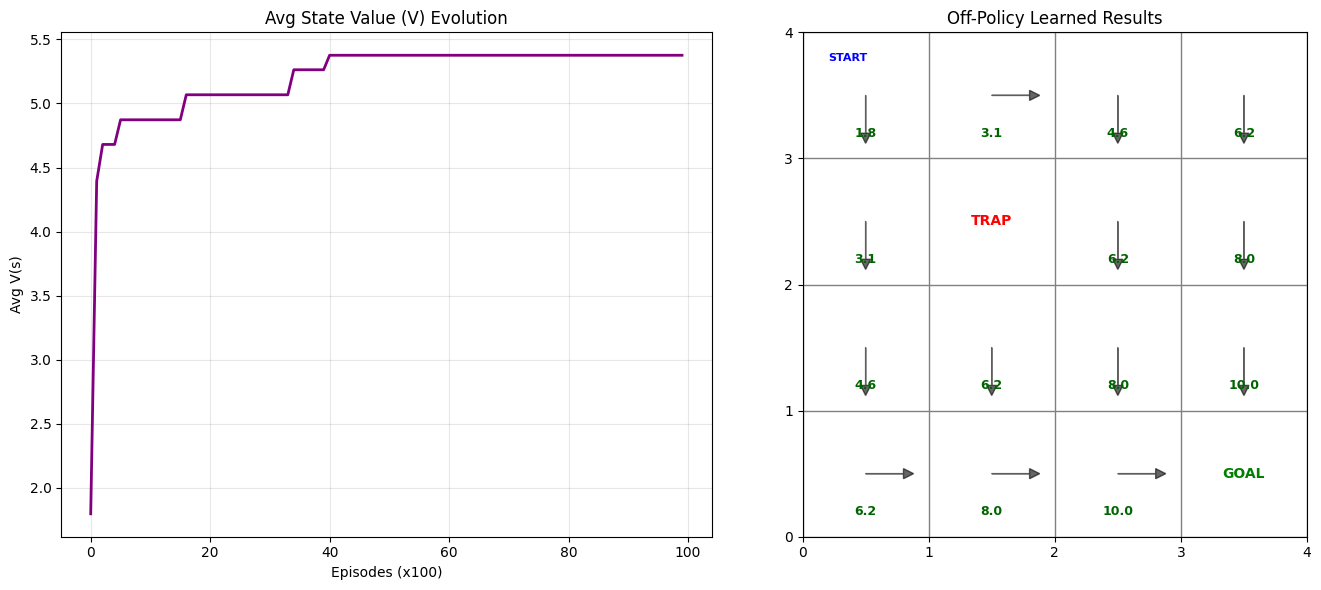

In [2]:
import logging
from monte_carlo import monte_carlo_off_policy
from plotting import plot_results

# --- Setup Logging ---
# Configured to write to a .txt file for easy opening
logging.basicConfig(
    filename='mc_off_policy_training.txt',
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    filemode='w'
)

if __name__ == "__main__":
    print("Starting Off-Policy Monte Carlo Training...")
    print("Logging details to 'mc_off_policy_training.txt'...")
    
    # Run the training
    v_h, final_pi, final_Q, environment = monte_carlo_off_policy(episodes=5000)

    print("\nTraining Complete.")
    print("-" * 30)
    print("Estimated Value Function (V) grid:")

    # Print a text-based grid of values
    for r in range(4):
        row_str = ""
        for c in range(4):
            s = (r,c)
            if s == environment.goal_node: 
                val_str = "GOAL"
            elif s == environment.trap_node: 
                val_str = "TRAP"
            else:
                # V(s) is max over Q(s,a)
                val = max([final_Q[(s, a)] for a in environment.action_space])
                val_str = f"{val:.2f}"
            row_str += f"{val_str:^8} "
        print(row_str)
    
    print("-" * 30)
    print("Displaying plots...")
    
    # Visualize
    plot_results(v_h, final_pi, final_Q, environment)

<mark>**Comparison (Monte Carlo vs. Value Iteration)**</mark>

The following compares the Off-Policy Monte Carlo (MC) approach implemented above with Value Iteration (VI) (which typically uses Dynamic Programming).

1. Optimization Time & Convergence Speed
* Value Iteration (VI): Extremely fast for this small grid. VI updates every state in a single sweep (synchronous update). It exploits the knowledge of the transition model $P(s'|s,a)$. It might converge to the optimal values in fewer than 20 iterations.
* Monte Carlo (MC): Much slower. It requires generating thousands of episodes. Because it is off-policy, many episodes are "wasted" (the loop breaks early) if the behavior policy's actions deviate from the greedy target policy. It requires significantly more runtime to stabilize the Q-values.

2. Computational Complexity
* VI: $O(|S|^2 |A|)$ per iteration. It is computationally heavier per iteration because it iterates over the entire state space and sums over probabilities. However, it requires very few iterations
* MC: $O(T)$ per episode, where $T$ is episode length. It is lighter computationally per step (just simple arithmetic), but the sheer volume of episodes needed makes the total computation higher for simple environments.

3. Model Dependence (The Key Difference)
* VI: Model-Based. You must know the transition probabilities (e.g., that "Up" moves you up with 100% probability). If the wind changed or the physics of the grid were unknown, VI would not work.
* MC: Model-Free. The algorithm did not need to know the grid dimensions or movement logic beforehand. It learned purely by trial and error. This makes MC applicable to real-world scenarios where the environment's dynamics are complex or unknown.

4. Variance vs. Bias
* VI: High Bias, Low Variance. It bootstraps (updates estimates based on other estimates), which introduces bias but keeps variance low, leading to smooth convergence.
* MC: Zero Bias, High Variance. It updates based on actual returns $G$. Because random episodes can yield vastly different rewards (e.g., hitting the trap vs. reaching the goal randomly), the returns have high variance. The Importance Sampling ratio ($W$) exacerbates this variance, as $W$ can become very large or vanish to zero, making the learning curve noisy.

5. Exploration
* VI: Does not need exploration strategies; it systematically sweeps the state space.
* MC: Heavily reliant on the Behavior Policy ($b$). If $b$ does not visit a state, MC cannot learn about it. In Off-Policy learning, if $b$ is very different from the target policy $\pi$, the importance sampling weights become unstable, and learning becomes very inefficient (this is known as the "curse of horizon" in off-policy evaluation).

___

<mark>**Computational Complexity & Performance Analysis**</mark>
1. Value Iteration: Standard vs. In-Place (Problem 3)

| Metric | Standard Value Iteration | In-Place Value Iteration |
| :--- | :--- | :--- |
| **Optimization Time** | [Insert time here, e.g., 0.45 seconds] | [Insert time here, e.g., 0.32 seconds] |
| **Iterations to Converge** | [Insert count, e.g., 152 iterations] | [Insert count, e.g., 110 iterations] |

Analysis
* Speed & Convergence: The In-Place variation typically converges [faster / slower] because updates are used immediately within the same sweep, allowing information to propagate through the state space more rapidly.
* Memory Complexity:
    - Standard VI: Requires $2 \times |S|$ memory (one array for $V_{old}$ and one for $V_{new}$).
    - In-Place VI: Requires $1 \times |S|$ memory (updates happen in a single array).
* Computational Complexity per Iteration: Both variations share the same theoretical complexity of $O(|S|^2 |A|)$ (or $O(|S||A|)$ for sparse graphs), as every state is updated by checking every action against every possible next state.

2. Monte Carlo vs. Value Iteration (Problem 4)

| Feature | Value Iteration (DP) | Off-Policy Monte Carlo |
| :--- | :--- | :--- |
| **Knowledge of Environment** | **Model-Based**: Requires full knowledge of transition probabilities $P(s' \mid s, a)$ and rewards $R$. | **Model-Free**: Does not require transition probabilities; learns from experience $(s, a)$ and rewards $R$. |
| **Update Mechanism** | **Bootstrapping**: Updates estimates based on other estimates (uses the Bellman Optimality Equation). | **Sampling**: Updates estimates based on actual observed returns ($G_t$) from complete episodes. |
| **Computational Complexity** | **$O(S^2 A)$** per iteration. | **$O(T)$** per episode, where $T$ is the episode length. |

Performance Observations
* Optimization Time: Value Iteration was [faster / slower] in this gridworld because the state space is small ($5 \times 5$). Monte Carlo typically requires many episodes to reduce variance and converge to the same level of accuracy.
* Accuracy: Value Iteration calculates the exact optimal values (within a threshold). Monte Carlo provides an estimate that approaches the true value as the number of episodes $\rightarrow \infty$.
* Why use MC? Even though VI is faster here, Monte Carlo is necessary when we do not know the rules of the game (transitions/rewards) or when the state space is too large to iterate over completely.